# **KAIST EE**
#  **[EE488] note 02A. CartPole (with a low level DQN code)**
## **Instructor**: Prof. Yoon, Young-Gyu (ygyoon@kaist.ac.kr)
### This example code was prepared by EE488 teaching assistants Han, Seungjae (jay0118@kaist.ac.kr) & Shin, Changyeop (scey26@kaist.ac.kr).

- Class Date : 22.03.xx.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

---

### 0. In this example, we will implement a simple  **DQN for solving CartPole** which is an inverted pendulum problem.

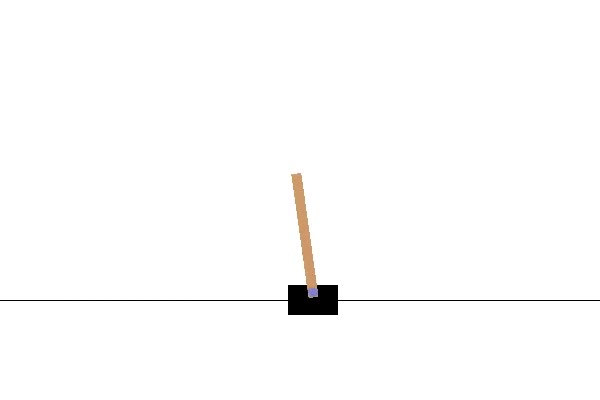


**CartPole-v1**
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/



### 1. As usual, let's start with **importing libraries**!

In [ ]:
import random 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math
import cv2
import time

import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

import gym                                    # this is for RL environment (https://gym.openai.com/)
from collections import deque               # this simplifies the implementation of the replay buffer



# For reproducibility, set seed for random functions.
SEED = 0

# set seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### 2. Let's **mount Google drive** so that we can save files as we need.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import sys
import os

filepath = "/content/drive/My Drive//01_LectureNotes/EE488_AI_Capstone/Colab/"  # Change this path for your Google drive setting.
sys.path.append(filepath)
experiment = "CartPole_02A"

if not os.path.exists(f"{filepath}"):
    os.makedirs(f"{filepath}")
if not os.path.exists(f"{filepath}/{experiment}"):
    os.makedirs(f"{filepath}/{experiment}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3. We need a bunch of stuff for **visualization** (as we are running on server without a physical display!). Let's not worry about the details here.

In [ ]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML, clear_output
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


### 4. Here's our function for visualization of the result as a **video**.

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### 5. Let's make the **environment**.

In [ ]:
ENV_NAME = "CartPole-v1"
env = gym.make(ENV_NAME) 
env.seed(SEED)

[0]

### 6. Let's define our **Q-network**.

In [ ]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

### 6. Let's define **ReplayMemory** that stores state, action, reward, and next_state (i.e., $(S_t, A_t, R_t, S_{t+1})$). This just a deque with a sampling function.

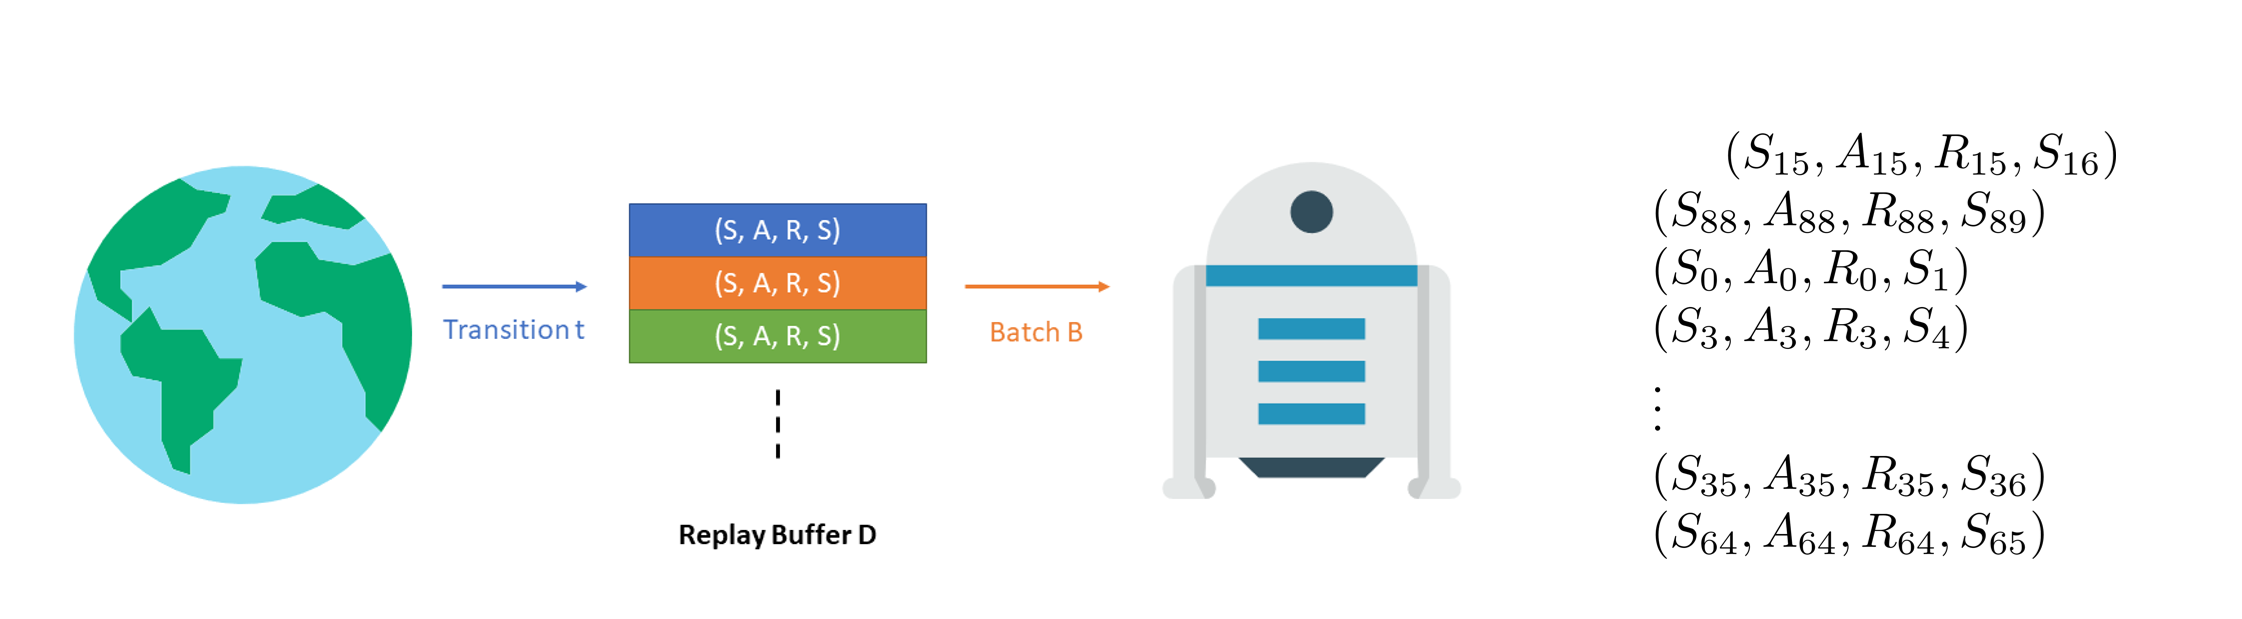

In [ ]:
class ReplayMemory(object):
    """Facilitates memory replay."""

    def __init__(self, buffer_size):
        self.memory = deque(maxlen=buffer_size)

    def append(self, m):
        self.memory.append(m)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return map(lambda x: Variable(torch.cat(x, 0).to(device)), zip(*batch))

### 7. Here is **preprocessing** function for CartPole game.

In [ ]:
def preprocess(state):
    return torch.Tensor(state).unsqueeze(0)

### 8. Here are our **hyperparameters**.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

buffer_size = 1000000 # size of replaymemory
fill_buffer = 128 # number of initial random (s, a, r, s') pairs before training 
batch_size = 128 # batch size
target_interval = 1000 # interval of updating Q_target
learn_interval = 1 # interval of updating Q
lr = 0.0005  # learning rate

save_interval = 100 # interval of saving trained model

max_time_steps = 500 # maximum length of each episode

# Hyperparameters for epsilon-greedy algorithm
epsilon = 0.01

discount = 0.99 # discount factor

max_episodes = 500

action_size = env.action_space.n

action_idx = np.arange(action_size)
probability = np.zeros(action_size, np.float32)

### 9. Here's our **replay buffer** (using ReplayMemory function we built). 

In [ ]:
memory = ReplayMemory(buffer_size)

### 10. Let's **initialize our networks** (Q-network & target network).

In [ ]:
Q = QNetwork().to(device)
Q_target = QNetwork().to(device)
optimizer = torch.optim.RMSprop(Q.parameters(), lr=lr, eps=0.001, alpha=0.95)
#optimizer = torch.optim.Adam(Q.parameters(), lr=lr)
criterion = nn.MSELoss()

### 11. Here is **function that select the action** with epsilon-greedy algorithm and get next state, reward, and done.

In [ ]:
def act(state, epsilon):
    # epsilon-greedy algorithm
    probability.fill(epsilon / action_size)
    with torch.no_grad():

        qvalues, argq = Q(state.to(device)).data.cpu().max(1) # obtain Q-value from the Q-function
        probability[argq.item()] += 1 - epsilon

        action = np.random.choice(action_idx, p=probability)

        next_state, reward, done, _ = env.step(action) # proceed one step based on the chosen action
        
        next_state = preprocess(next_state)  

        memory.append(
            (state, torch.LongTensor([int(action)]), torch.Tensor([reward]), next_state, torch.Tensor([done]))
        )
        return next_state, reward, done, action # qvalues.item()

### 12. Define a function to **keep track of the performance**.

In [ ]:
def plt_history():
    clear_output(True)
    plt.figure(figsize=[16, 9])
    plt.subplot(1, 2, 1)
    plt.title("Reward history")
    line1, = plt.plot(reward_history)
    line2, = plt.plot(reward_best_history)
    plt.legend(handles=(line1, line2), labels=('reward', 'best_reward'))

    plt.subplot(1,2,2)
    plt.title("Loss history")
    plt.plot(loss_history)
    target_update_loss = []
    for i in target_update_episode_history:
        target_update_loss.append(loss_history[i])
    plt.scatter(target_update_episode_history, target_update_loss, c='r', s=3)
    
    plt.grid()
    plt.show()

### 13. **Fill replaymemory** with random actions.

In [ ]:
print(f"init replay memory with {fill_buffer} entries")

state = preprocess(env.reset())

ep_len = 0
for _ in range(fill_buffer):
    next_state, _, done, _ = act(state, epsilon)
    state = preprocess(env.reset()) if (done or ep_len > max_time_steps) else next_state
    ep_len = 0 if (done or ep_len > max_time_steps) else ep_len + 1

print(f"Current length of memory : {len(memory.memory)}")

init replay memory with 128 entries
Current length of memory : 128


### 14. This is the **main loop for training**.

We randomly samples a batch of $ (S, A, R, S')$ from the replay 
buffer and then calculate the following loss and to perform back-propagation.

$$ \mathcal{L} = (Q(s,a) - \mathbb{E}[r+ \gamma Q_{target}(s',a')])^2  $$


Compare the code with the following pseudo-code.



<font color='purple'>Initialize</font> replay buffer

<font color='purple'>Initialize</font> Q network with random weights $\theta$

<font color='purple'>Initialize</font> target network (Q’) with $\theta^{-}=\theta$

<font color='purple'>for</font> episode in <font color='brown'>range</font>(n_episode):

> <font color='purple'>Initialize</font> sequence $s_1$ 

> <font color='purple'>for</font>  t in <font color='brown'>range</font>(t_max):

>>  <font color='purple'>if</font>  random variable <  $\epsilon$:	
>>> select random action $a_t$		

>> <font color='purple'>else</font>:
>>> <font color='purple'>select</font>  $a_t = \arg \max_a Q(s_t, a;\theta) $ 

>>  <font color='purple'>perform</font> $a_t$ and take $r_t$ and $s_{t+1}$

>>  <font color='purple'>store</font> $(s_t, a_t, r_t , s_{t+1})$ in replay buffer



>>  <font color='purple'>sample</font> a minibatch of $(s_k, a_k, r_k , s_{k+1})$ from replay buffer


>>  <font color='purple'>if</font>   episode terminates at step $k+1$:
>>> $y_k = r_k$ 			 

>> <font color='purple'>else</font>:

>>> $y_k = r_k + \gamma \arg \max_a Q(s_k, a_k;\theta^{-})$

>> Update $ \theta \leftarrow \theta - \alpha \nabla (y_k - Q(s_k, a_k;\theta^{-})^2 $

>> Update $ \theta^{-} \leftarrow \theta$ every C steps


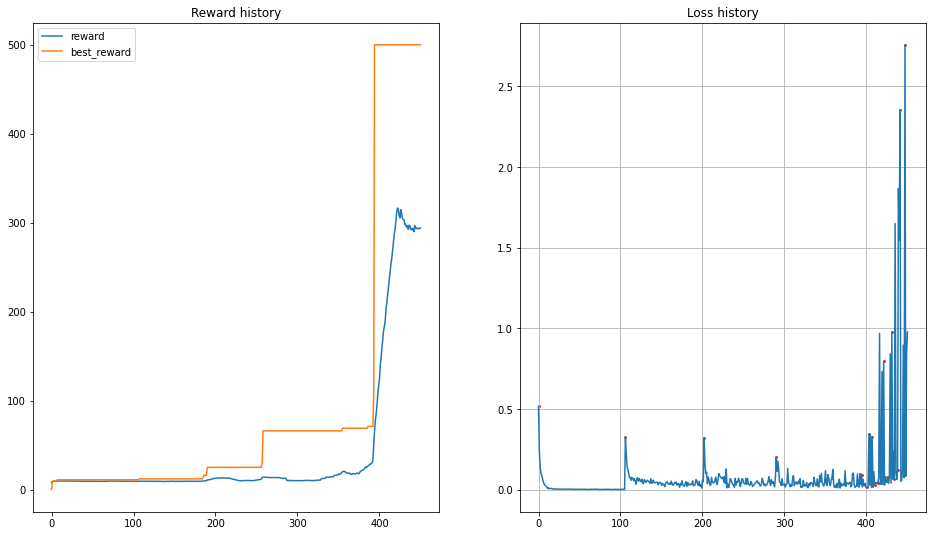

episode 450 (22741): time 0.87s mem 22869 eps 0.01000 len 249 r 249.000 avg_r 294.000
episode 451 (23013): time 0.59s mem 23141 eps 0.01000 len 272 r 272.000 avg_r 291.167
episode 452 (23274): time 0.55s mem 23402 eps 0.01000 len 261 r 261.000 avg_r 291.267
episode 453 (23627): time 0.74s mem 23755 eps 0.01000 len 353 r 353.000 avg_r 287.433
episode 454 (23872): time 0.55s mem 24000 eps 0.01000 len 245 r 245.000 avg_r 286.400
episode 455 (24272): time 0.90s mem 24400 eps 0.01000 len 400 r 400.000 avg_r 290.167
episode 456 (24504): time 0.50s mem 24632 eps 0.01000 len 232 r 232.000 avg_r 281.233
episode 457 (24804): time 0.67s mem 24932 eps 0.01000 len 300 r 300.000 avg_r 283.967
episode 458 (25059): time 0.85s mem 25187 eps 0.01000 len 255 r 255.000 avg_r 285.333
episode 459 (25339): time 0.65s mem 25467 eps 0.01000 len 280 r 280.000 avg_r 286.967
episode 460 (25630): time 0.63s mem 25758 eps 0.01000 len 291 r 291.000 avg_r 288.633
episode 461 (25845): time 0.48s mem 25973 eps 0.01000 

In [ ]:
t = 0
recent_rewards = deque(maxlen=30)

reward_history = []
reward_best_history = []
loss_history = []

target_update_episode_history = []

best_rewards = 0

for ep in range(max_episodes):
    state = preprocess(env.reset())

    done = False
    ep_len = 0
    start_time = time.time()
    
    score = 0
    while not done and ep_len < max_time_steps:
        if t % target_interval == 0:
            Q_target.load_state_dict(Q.state_dict())
            target_update_episode_history.append(ep)
        
        next_state, reward, done, action = act(state, epsilon)

        score += reward
        state = next_state

        t += 1
        ep_len += 1

        if ep_len % learn_interval == 0:

            states, actions, rewards, next_states, dones = memory.sample(batch_size)
            
            pred = Q(states).gather(1, actions.unsqueeze(1)).squeeze(1)            
            target = rewards + (1 - dones) * discount * Q_target(next_states).max(1)[0]
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()            
            # clip = 1.0
            # nn.utils.clip_grad_norm(Q.parameters(), clip)
            # [Optional] Gradient clipping for stable training.
            optimizer.step()
    
    # measuring stuffs.
    recent_rewards.append(score)
    recent_average_reward = np.mean(recent_rewards)
    reward_history.append(recent_average_reward)
    reward_best_history.append(best_rewards)
    loss_history.append(loss.item())

    # save the best model
    # Note that best reward can occure by chance (due to eplison)
    if score > best_rewards:
        best_rewards = score
        torch.save(Q.state_dict(), f"{filepath}/{experiment}/best_reward_Q.pt")
    
    # Let's end if recent average reward goes higher than 450.
    # This model may do better than "best_reward_Q_{ep}.pt".
    if recent_average_reward > 450:
        torch.save(Q.state_dict(), f"{filepath}/{experiment}/best_Q.pt")
        plt_history()
        break

    # Save the Q, Q_target, and optimizer every save_interval.
    if ep % save_interval == 0:
        torch.save(Q.state_dict(), f"{filepath}/{experiment}/Q_{ep}.pt")
        torch.save(Q_target.state_dict(), f"{filepath}/{experiment}/Q_target_{ep}.pt")
        torch.save(optimizer.state_dict(), f"{filepath}/{experiment}/optimizer_{ep}.pt")
        
    # Plot history.
    if ep % 50 == 0:
        plt_history()

    
    print(
        "episode %d (%d): time %.2fs mem %d eps %.5f len %d r %.3f avg_r %.3f"
        % (
            ep,
            t,
            time.time() - start_time,
            len(memory.memory),
            epsilon,
            ep_len,
            score,
            recent_average_reward
        )
    )


env.close()

### 16. Now, let's **evaluate** the performance of the trained network!

In [ ]:
model_path = f"{filepath}/{experiment}/best_reward_Q.pt" # Good
# model_path = f"{filepath}/{experiment}/best_Q.pt" # Also Good

Q.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def act_vis(state, epsilon):
    # epsilon-greedy algorithm
    probability.fill(epsilon / action_size)
    with torch.no_grad():
        qvalues, argq = Q(state.to(device)).data.cpu().max(1)
        probability[argq.item()] += 1 - epsilon
        action = np.random.choice(action_idx, p=probability)
        next_state, reward, done, _ = env_vis.step(action)
        next_state = preprocess(next_state)

        return next_state, reward, done, action # qvalues.item()

In [ ]:
env_vis = wrap_env(gym.make(ENV_NAME))
env_vis.seed(SEED + 1)
state = env_vis.reset()
state = preprocess(state)

In [ ]:
current_epsilon = 0.0
done = False
score = 0
ep_len = 0

while not done and ep_len < max_time_steps:
    with torch.no_grad():
        next_state, reward, done, action = act_vis(state, current_epsilon)

        score += reward
        state = next_state

        env_vis.render()
        time.sleep(0.01)


print(f'Reward is {score}.')

env_vis.close()
show_video()

Reward is 500.0.


### **Congratulations**! You sucessfully trained a DQN!